In [1]:
# %load ../jupyter_setup.txt
# Convenient jupyter setup
%load_ext autoreload
%autoreload 2
%config IPCompleter.greedy=True
%config IPCompleter.use_jedi=False 

In [2]:
import numpy as np
import geopandas as gpd
import shapely
from typing import Iterable, Tuple, Dict

import matplotlib.pyplot as plt
import seaborn as sns

from src.constants import SRC_PATH
from src.data_loading.rasterio_utils import polygonise
from src.data_loading.vector_utils import shapely_to_frame
from src.tests.utils import polygonise_sub_array, plot_identified_nodes, get_array_transform
from src.models.geograph import GeoGraph
from src.models.binary_graph_operations import identify_node

/home/users/svm/Code/gtc-biodiversity/env/lib/python3.8/site-packages/geopandas/_compat.py:84: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.9.0-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(


In [3]:
TEST_DATA_FOLDER = SRC_PATH / "tests" / "testdata"
TEST_DATA_FOLDER.mkdir(parents=True, exist_ok=True)

In [4]:
full = GeoGraph(TEST_DATA_FOLDER / "adjacent" / "full.gpkg")
upper_right = GeoGraph(TEST_DATA_FOLDER / "adjacent" / "upper_right.gpkg")
upper_left = GeoGraph(TEST_DATA_FOLDER / "adjacent" / "upper_left.gpkg")
lower_right = GeoGraph(TEST_DATA_FOLDER / "adjacent" / "lower_right.gpkg")
lower_left = GeoGraph(TEST_DATA_FOLDER / "adjacent" / "lower_left.gpkg")

/home/users/svm/Code/gtc-biodiversity/env/lib/python3.8/site-packages/geopandas/geodataframe.py:422: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:
Step 1 of 2: Creating nodes and finding neighbours: 100%|██████████| 15/15 [00:00<00:00, 789.59it/s]
Step 2 of 2: Adding edges: 100%|██████████| 15/15 [00:00<00:00, 32682.89it/s]
Step 1 of 2: Creating nodes and finding neighbours: 100%|██████████| 4/4 [00:00<00:00, 807.45it/s]
Step 2 of 2: Adding edges: 100%|██████████| 4/4 [00:00<00:00, 21620.12it/s]


Graph successfully loaded with 15 nodes and 40 edges.
Graph successfully loaded with 4 nodes and 4 edges.


Step 1 of 2: Creating nodes and finding neighbours: 100%|██████████| 3/3 [00:00<00:00, 537.13it/s]
Step 2 of 2: Adding edges: 100%|██████████| 3/3 [00:00<00:00, 13934.56it/s]
Step 1 of 2: Creating nodes and finding neighbours: 100%|██████████| 6/6 [00:00<00:00, 592.92it/s]
Step 2 of 2: Adding edges:   0%|          | 0/6 [00:00<?, ?it/s]

Graph successfully loaded with 3 nodes and 3 edges.


Step 2 of 2: Adding edges: 100%|██████████| 6/6 [00:00<00:00, 32768.00it/s]
Step 1 of 2: Creating nodes and finding neighbours: 100%|██████████| 4/4 [00:00<00:00, 735.10it/s]
Step 2 of 2: Adding edges: 100%|██████████| 4/4 [00:00<00:00, 28484.24it/s]

Graph successfully loaded with 6 nodes and 11 edges.
Graph successfully loaded with 4 nodes and 6 edges.


In [9]:
def polygonise_splits(arr: np.ndarray, 
                       named_slices: Iterable[Dict[str, Tuple]]
                      ):
    
    result = {}
    for name, (x_lims, y_lims) in named_slices.items(): 
        result[name] = polygonise_sub_array(arr, x_lims, y_lims)
        
    return result

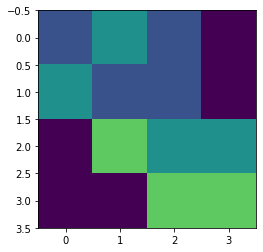

In [10]:
np.random.seed(285)
low = 1
high = 5
# Samples 2: Overlapping polygons
arr2 = np.random.randint(low=low, high=high, size=(4,4), dtype=np.uint8)
plt.imshow(arr2, vmin=low, vmax=high);

splits_of_interest = {
    "lower_left": ((0,3), (0,3)),
    "upper_right": ((1,4), (1,4)),
    "upper_left": ((0,3), (1,4)),
    "lower_right": ((1,4), (0,3))
}

polys2 = polygonise_splits(arr2, splits_of_interest)
polys2["full"] = polygonise(arr2, transform=get_array_transform(arr2))

In [15]:
df= polys2["full"]

In [16]:
df

,geometry,class_label
0,"POLYGON ((0.00000 4.00000, 1.00000 4.00000, 1....",2
1,"POLYGON ((1.00000 4.00000, 2.00000 4.00000, 2....",3
2,"POLYGON ((3.00000 4.00000, 4.00000 4.00000, 4....",1
3,"POLYGON ((0.00000 3.00000, 1.00000 3.00000, 1....",3
4,"POLYGON ((2.00000 4.00000, 3.00000 4.00000, 3....",2
5,"POLYGON ((0.00000 2.00000, 1.00000 2.00000, 1....",1
6,"POLYGON ((1.00000 2.00000, 2.00000 2.00000, 2....",4
7,"POLYGON ((2.00000 2.00000, 4.00000 2.00000, 4....",3
8,"POLYGON ((2.00000 1.00000, 4.00000 1.00000, 4....",4


<AxesSubplot:>

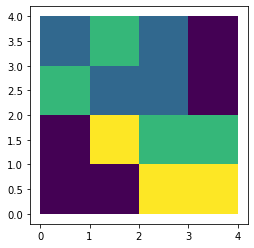

In [18]:
df.plot("class_label")

In [19]:
df.sindex

In [26]:
geom = df.iloc[0]["geometry"]

In [32]:
%%timeit
df.sindex.query(geom, predicate="intersects")

121 µs ± 8.2 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [31]:
df.sindex.geometries

array([<pygeos.Geometry POLYGON ((0 4, 1 4, 1 3, 0 3, 0 4))>,
       <pygeos.Geometry POLYGON ((1 4, 2 4, 2 3, 1 3, 1 4))>,
       <pygeos.Geometry POLYGON ((3 4, 4 4, 4 2, 3 2, 3 4))>,
       <pygeos.Geometry POLYGON ((0 3, 1 3, 1 2, 0 2, 0 3))>,
       <pygeos.Geometry POLYGON ((2 4, 3 4, 3 2, 2 2, 1 2, 1 3, 2 3, 2 4))>,
       <pygeos.Geometry POLYGON ((0 2, 1 2, 1 1, 2 1, 2 0, 0 0, 0 2))>,
       <pygeos.Geometry POLYGON ((1 2, 2 2, 2 1, 1 1, 1 2))>,
       <pygeos.Geometry POLYGON ((2 2, 4 2, 4 1, 2 1, 2 2))>,
       <pygeos.Geometry POLYGON ((2 1, 4 1, 4 0, 2 0, 2 1))>],
      dtype=object)

In [28]:
df2 = df.drop([2,4])

In [30]:
df2.sindex.geometries

array([<pygeos.Geometry POLYGON ((0 4, 1 4, 1 3, 0 3, 0 4))>,
       <pygeos.Geometry POLYGON ((1 4, 2 4, 2 3, 1 3, 1 4))>,
       <pygeos.Geometry POLYGON ((0 3, 1 3, 1 2, 0 2, 0 3))>,
       <pygeos.Geometry POLYGON ((0 2, 1 2, 1 1, 2 1, 2 0, 0 0, 0 2))>,
       <pygeos.Geometry POLYGON ((1 2, 2 2, 2 1, 1 1, 1 2))>,
       <pygeos.Geometry POLYGON ((2 2, 4 2, 4 1, 2 1, 2 2))>,
       <pygeos.Geometry POLYGON ((2 1, 4 1, 4 0, 2 0, 2 1))>],
      dtype=object)